## Siamese model

A Siamese neural network (sometimes called a twin neural network) is an artificial neural network that uses the same weights and special loss to calculate the distance between vectors. The similarity measure used to train the model makes more closer anchor and positive examples than anchor and negatives.
![Siamese network](https://miro.medium.com/max/1996/1*ChM99rEEcqL0K9ZUoB_UrA.png)


**Algorithm assumptions**

The Siamese Network algorithm will be built based on the training set and then validated on the test and training sets. The basic assumption of the model is to embedded images into lower dimensions via a neural network, and then compare the pairs of the [anchor, positive] and [anchor, negative] types with Triplet Loss. Similar to the PCA method, siamese allows us to determine the average threshold at which the algorithm can determine whether the presented faces in pairs are the same people or not. Then the threshold calculated from the training set will be used to determine whether the face pairs in the training and test sets are the same. This way the accuracy will be calculated and the threshold could be used in the production phase.

**Machine Learning Workflow**

To test the siamese network, I will go through several steps:

- Loading data from S3
- Create traning job with custom traning code based on TensorFlow
- Calculate distance threshold with train data
- Validate algorithm with test / val dataset
- Examine results

### Install packages, loading libraries, and create environment variables

In [16]:
# install additional package
!pip install hyperopt

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [17]:
# data managing and display libs
import pandas as pd
import numpy as np
import os
import io
from tqdm.auto import tqdm
# sagemaker libraries
import boto3
import sagemaker
from sagemaker import get_execution_role

# s3fs library imports and creates s3 object
from s3fs.core import S3FileSystem
s3 = S3FileSystem()

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## Loading data from S3

Similar to the PCA modeling dataset is already in an Amazon S3 bucket, it was created in the first stage notebook where we explore and dump the dataset to local storage and s3. Similar to the PCA notebook, I will use the s3fs library which allows mounting an S3 bucket via FUSE.

In [18]:
import os
import json
import sagemaker
from sagemaker.tensorflow import TensorFlow
from sagemaker import get_execution_role

sess = sagemaker.Session()

# get default data bucket
bucket = sess.default_bucket()
# get IAM role
role = get_execution_role()

input_path = f"s3://{bucket}/ml_capstone/face_recognition/"
output_path = f"s3://{bucket}/ml_capstone/tensorflow"

print('Role used by SageMaker: ', role)
print('Default S3 bucket: ', bucket)

Role used by SageMaker:  arn:aws:iam::081489346219:role/c20300a265023u1343687t1w0-SageMakerNotebookInstanc-YHJZOL3CFWPI
Default S3 bucket:  sagemaker-us-east-1-081489346219


## Create traning job with custom traning code based on TensorFlow

To train the Tensorflow model, I have created a traning script inside the code directory named train.py. Inside the script, TensorFlow 2 Framework was used. Script mode is a popular method for traning custom algorithms with AWS Sagemaker containers.

Sagemaker SDK allows us to test the script in local mode, as shown below. In the local mode, it is possible to test the script without instantiating an on AWS. Moreover, AWS Sagemaker offers the possibility of using spot instance traning which can reduce costs. However, in our experiment, we focused on the experiment time, so we did not use spot instances.

For the purposes of training, the following parameters were used: batch_size = 1024 and epochs = 500, in addition, the so-called Early stopping callbacks are used.

In [19]:
from sagemaker.tensorflow import TensorFlow

local_mode = False

if local_mode:
    instance_type = "local"
else:
    instance_type = "ml.g4dn.xlarge"

    
hyperparams = hyperparameters={
        "batch_size": 256,
        "epochs": 500,
        "n_components": 150
    }
    
tf_estimator = TensorFlow(
             entry_point='train.py',
             source_dir='code',
             sagemaker_session=sess,
             role=role,
             instance_count=1,
             instance_type=instance_type,
             framework_version="2.3.1",
             py_version="py37",
             output_path=output_path,
             hyperparameters=hyperparams)

tf_estimator.fit(inputs={'train': input_path})

2021-06-29 21:29:42 Starting - Starting the training job...
2021-06-29 21:30:06 Starting - Launching requested ML instancesProfilerReport-1625002182: InProgress
......
2021-06-29 21:31:07 Starting - Preparing the instances for training.........
2021-06-29 21:32:42 Downloading - Downloading input data
2021-06-29 21:32:42 Training - Downloading the training image............
2021-06-29 21:34:27 Training - Training image download completed. Training in progress.2021-06-29 21:34:27.310309: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-06-29 21:34:27.314442: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2021-06-29 21:34:27.504445: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.2
2021-06-29 21:34:27.586025: W tensorflow/core/p

[2021-06-29 21:34:42.053 ip-10-0-208-13.ec2.internal:24 INFO json_config.py:91] Creating hook from json_config at /opt/ml/input/config/debughookconfig.json.
[2021-06-29 21:34:42.054 ip-10-0-208-13.ec2.internal:24 INFO hook.py:199] tensorboard_dir has not been set for the hook. SMDebug will not be exporting tensorboard summaries.
[2021-06-29 21:34:42.054 ip-10-0-208-13.ec2.internal:24 INFO hook.py:253] Saving to /opt/ml/output/tensors
[2021-06-29 21:34:42.055 ip-10-0-208-13.ec2.internal:24 INFO state_store.py:75] The checkpoint config file /opt/ml/input/config/checkpointconfig.json does not exist.
[2021-06-29 21:34:42.067 ip-10-0-208-13.ec2.internal:24 INFO hook.py:413] Monitoring the collections: metrics, losses, sm_metrics
Epoch 1/500
#0151/8 [==>...........................] - ETA: 0s - loss: 29.9940 - batch: 0.0000e+00#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

#0151/8 [==>...........................] - ETA: 0s - loss: 0.0041#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0152/8 [======>.......................] - ETA: 1s - loss: 0.0114#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153/8 [==========>...................] - ETA: 1s - loss: 0.0161#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0154/8 [==============>...............] - ETA: 1s - loss: 0.0182#010#010

#0151/8 [==>...........................] - ETA: 0s - loss: 0.0048#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0152/8 [======>.......................] - ETA: 1s - loss: 0.0024#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153/8 [==========>...................] - ETA: 1s - loss: 0.0016#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0154/8 [==============>...............] - ETA: 1s - loss: 0.0021#010#010

#0151/8 [==>...........................] - ETA: 0s - loss: 0.0011#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0152/8 [======>.......................] - ETA: 1s - loss: 5.8849e-04#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153/8 [==========>...................] - ETA: 1s - loss: 6.4580e-04#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0154/8 [==============>.........

#0151/8 [==>...........................] - ETA: 0s - loss: 0.0043#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0152/8 [======>.......................] - ETA: 1s - loss: 0.0045#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153/8 [==========>...................] - ETA: 1s - loss: 0.0052#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0154/8 [==============>...............] - ETA: 1s - loss: 0.0055#010#010

#0151/8 [==>...........................] - ETA: 0s - loss: 0.0033#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0152/8 [======>.......................] - ETA: 1s - loss: 0.0090#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153/8 [==========>...................] - ETA: 1s - loss: 0.0060#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0154/8 [==============>...............] - ETA: 1s - loss: 0.0047#010#010

#0151/8 [==>...........................] - ETA: 0s - loss: 4.7074e-04#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0152/8 [======>.......................] - ETA: 1s - loss: 2.3537e-04#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153/8 [==========>...................] - ETA: 1s - loss: 1.5691e-04#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0154/8 [====

#0151/8 [==>...........................] - ETA: 0s - loss: 0.0000e+00#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0152/8 [======>.......................] - ETA: 1s - loss: 0.0000e+00#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153/8 [==========>...................] - ETA: 1s - loss: 0.0000e+00#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0154/8 [====

#0151/8 [==>...........................] - ETA: 0s - loss: 0.0000e+00#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0152/8 [======>.......................] - ETA: 1s - loss: 0.0000e+00#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153/8 [==========>...................] - ETA: 1s - loss: 0.0000e+00#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0154/8 [====

#0151/8 [==>...........................] - ETA: 0s - loss: 0.0000e+00#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0152/8 [======>.......................] - ETA: 1s - loss: 0.0000e+00#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153/8 [==========>...................] - ETA: 1s - loss: 0.0000e+00#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0154/8 [====

#0151/8 [==>...........................] - ETA: 0s - loss: 0.0000e+00#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0152/8 [======>.......................] - ETA: 1s - loss: 0.0000e+00#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153/8 [==========>...................] - ETA: 1s - loss: 0.0000e+00#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0154/8 [====

### Deploy the Siamese Model¶

We can now deploy the Siamese network and use it to make predictions.

In [20]:
# setups
from sagemaker.tensorflow import TensorFlowModel

In [21]:
model = TensorFlowModel(
    role=role,
    model_data=tf_estimator.model_data,
    framework_version="2.3.1",
)

In [22]:
# set local_mode to False if you want to deploy on a remote
# SageMaker instance

predictor = model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
)

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


---------------!

### Predict based on endpoint

Based on the endpoint that we have created, we can transform the images into an Embedding vector with a specified output of the final layer in the Siamese network. Since we have put the algorithm on a relatively small instance, we will perform the batch predictions with a certain number of requests, similar to PCA.

To correctly determine the threshold, we make predictions on anchor images, and then on positive/negative pair, thus will be able to determine the threshold for which we assume that a given face is the same as the base face.

In [24]:
def batch_prediction(data, predictor, embedding_size, batch_size=100):
    numpy_frame = np.zeros((data.shape[0], embedding_size))
    for bs in tqdm(range(0, data.shape[0], batch_size)):
        # predict using endpoints
        batch_prediction = predictor.predict(data[bs:bs+batch_size])['predictions']
        numpy_frame[bs:bs+batch_size] = np.array(batch_prediction)
    return numpy_frame

N_COMPONENTS = hyperparams["n_components"]
train_data = np.load(s3.open(f'{input_path}X_train_siamese.npy'))

train_siamese_anchor = batch_prediction(train_data[:, 0, :], predictor, N_COMPONENTS)
train_siamese_positives = batch_prediction(train_data[:, 1, :], predictor, N_COMPONENTS)
train_siamese_negatives = batch_prediction(train_data[:, 2, :], predictor, N_COMPONENTS)

train_siamese_base = np.vstack((train_siamese_anchor, train_siamese_anchor))
train_siamese_embeddings = np.vstack((train_siamese_positives, train_siamese_negatives))

train_labels = np.hstack(([1]*len(train_siamese_positives), [0]*len(train_siamese_negatives)))

print(f'Train data anchors shape: {train_siamese_base.shape}')
print(f'Train data samples shape: {train_siamese_embeddings.shape}')
print(f'Train data labels shape: {train_labels.shape}')

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Train data anchors shape: (4064, 150)
Train data samples shape: (4064, 150)
Train data labels shape: (4064,)


### Calculate distance threshold with train data

Similar to the PCA model we will calculate the threshold based on distance metric and hyperopt

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, cohen_kappa_score, precision_score

# import hyperopt libraries
from hyperopt import fmin, tpe, hp, Trials, space_eval


def calculate_distances(anchor_embedding, sample_embedding, metric='euclidean'):
    metrics = ['euclidean', 'cosine']
    # calcyulate pairwise euclidean distance
    if metric == metrics[0]:
        return np.linalg.norm(anchor_embedding-sample_embedding, axis=1)
    # calculate cosine distance
    elif metric == metrics[1]:
        return 1-np.diag(cosine_similarity(anchor_embedding, sample_embedding), k=0)
    else:
        raise ValueError(f'{metric} not implemented, use one of {metrics} metrics')


def scorer(y, y_sim):
    # create dictionary with basic metrics
    func = [accuracy_score, f1_score, roc_auc_score, cohen_kappa_score]
    names = ['Accuracy', 'F1', 'ROC_AUC', 'COHEN_KAPPA']
    score = dict()
    for f, name in zip(func, names):
        score[name] = f(y, y_sim)

    return score


## Create optimization threshold script
def threshold_optimization(dataset, labels, threshold_max, max_evals):

    def minimize(threshold):
        binary_score = np.where(data < threshold, 1, 0)
        return 1-accuracy_score(labels, binary_score)  # change metric if you want optimize based on other one

    # optimize the threshold based on f1 metric
    best = fmin(fn=minimize,
        space=hp.uniform('threshold', 0, threshold_max),
        algo=tpe.suggest,
        max_evals=max_evals,
        rstate = np.random.RandomState(1))
    
    thresh = best['threshold']
    
    acc = accuracy_score(labels, np.where(data < thresh, 1, 0))
    print(f'Best threshold: {thresh}')
    print(f'Accuracy score {acc}')
    return thresh

In [26]:
data = calculate_distances(train_siamese_base, train_siamese_embeddings, metric='euclidean')
threshold = threshold_optimization(data, train_labels, 100, 400)

100%|██████████| 400/400 [00:02<00:00, 179.76trial/s, best loss: 0.11564960629921262]
Best threshold: 3.113685684468755
Accuracy score 0.8843503937007874


## Validate algorithm with test / val dataset

In [27]:
test_data = np.load(s3.open(f'{input_path}X_test_pca.npy')).astype('float32')

test_siamese_anchor = batch_prediction(test_data[:, 0, :], predictor, N_COMPONENTS)
test_siamese_samples = batch_prediction(test_data[:, 1, :], predictor, N_COMPONENTS)
test_labels =  np.load(s3.open(f'{input_path}y_test_pca.npy'))

print(f'Train data anchors shape: {test_siamese_anchor.shape}')
print(f'Train data samples shape: {test_siamese_samples.shape}')
print(f'Train data labels shape: {test_labels.shape}')


test_distances = calculate_distances(test_siamese_anchor, test_siamese_samples, metric='euclidean')

scorer(test_labels, np.where(test_distances < threshold, 1, 0))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train data anchors shape: (508, 150)
Train data samples shape: (508, 150)
Train data labels shape: (508,)


{'Accuracy': 0.7303149606299213,
 'F1': 0.739047619047619,
 'ROC_AUC': 0.7303149606299213,
 'COHEN_KAPPA': 0.4606299212598425}

In [28]:
validation_data = np.load(s3.open(f'{input_path}X_val_final.npy')).astype('float32')

val_pca_anchor = batch_prediction(validation_data[:, 0, :], predictor, N_COMPONENTS)
val_pca_samples = batch_prediction(validation_data[:, 1, :], predictor, N_COMPONENTS)
val_labels = np.load(s3.open(f'{input_path}y_val_final.npy'))

print(f'Train data anchors shape: {val_pca_anchor.shape}')
print(f'Train data samples shape: {val_pca_samples.shape}')
print(f'Train data labels shape: {val_labels.shape}')


val_distances = calculate_distances(val_pca_anchor, val_pca_samples, metric='euclidean')

scorer(val_labels, np.where(val_distances < threshold, 1, 0))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train data anchors shape: (254, 150)
Train data samples shape: (254, 150)
Train data labels shape: (254,)


{'Accuracy': 0.7204724409448819,
 'F1': 0.7300380228136881,
 'ROC_AUC': 0.7204724409448818,
 'COHEN_KAPPA': 0.4409448818897638}

## Examine results

We can see the results for the test, training, and validation are different, which means that our model overfits slightly. 

The Siamese Network base model achieved **0.72 accuracy** for the validation set. This is ~15% better results than the PCA base model. We can assume that more data or a better backbone model could help to stabilize the score similar to the accuracy achieved on train data ~0.88. Also, we see that histograms have clearly shift when the label is equal to 1 (positive pair), so we can assume that model is much better than the simple PCA method.

In [29]:
import seaborn as sns

def make_plot(distance, labels):
    df = pd.DataFrame({'distance': distance, 'labels': labels})
    sns.displot(df, x='distance', kde=True, col='labels')
    plt.show()

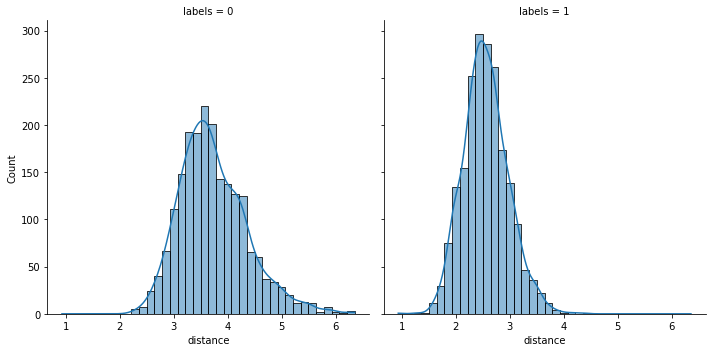

In [30]:
make_plot(data, train_labels)

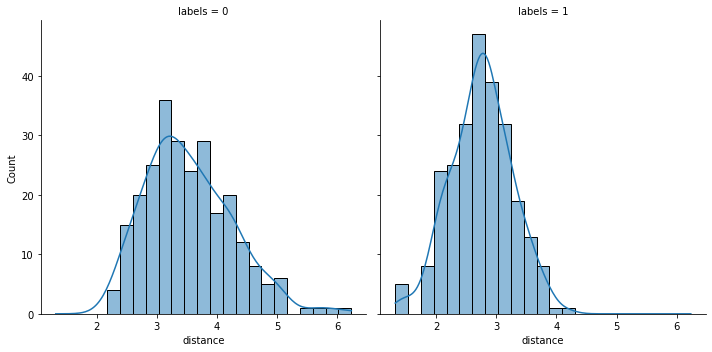

In [31]:
make_plot(test_distances, test_labels)

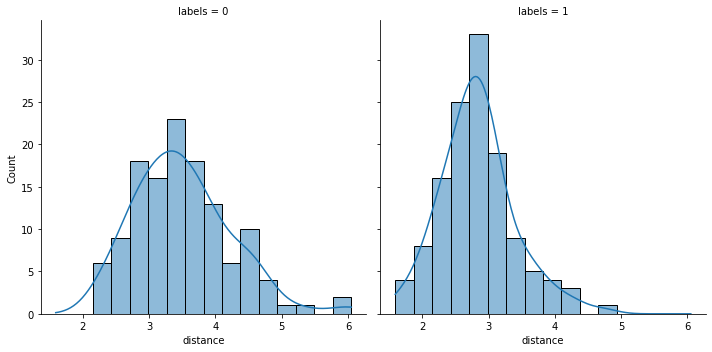

In [32]:
make_plot(val_distances, val_labels)

In [33]:
predictor.delete_endpoint()